## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from datetime import datetime

In [2]:
# Set styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load the datasets - PATIENTS, PRESCRIPTIONS and TRANSFERS Table

In [3]:
patients = pd.read_csv('data/PATIENTS.csv')
prescriptions = pd.read_csv('data/PRESCRIPTIONS.csv')
transfers = pd.read_csv('data/TRANSFERS.csv')

/var/folders/53/t0lk0nc97355b8lqtgt3n97h0000gn/T/ipykernel_12084/752967680.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv('data/PRESCRIPTIONS.csv')


In [4]:
# Display basic info
print("PATIENTS shape:", patients.shape)
print("PRESCRIPTIONS shape:", prescriptions.shape)
print("TRANSFERS shape:", transfers.shape)


PATIENTS shape: (46520, 8)
PRESCRIPTIONS shape: (4156450, 19)
TRANSFERS shape: (261897, 13)


## Data preprocessing

In [5]:
# Convert dates to datetime format
patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'])

transfers['INTIME'] = pd.to_datetime(transfers['INTIME'])
transfers['OUTTIME'] = pd.to_datetime(transfers['OUTTIME'])


In [6]:
# Calculate age function
def calculate_age(dob, dod):
    print(dob)
    print(dod)
    # Check if DOB or DOD is NaN
    if pd.isna(dob) or pd.isna(dod):
        return np.nan  # or return None if you prefer
    
    dob_date = datetime.strptime(str(dob), "%Y-%m-%d %H:%M:%S")
    dod_date = datetime.strptime(str(dod), "%Y-%m-%d %H:%M:%S")
    age = (dod_date - dob_date).days // 365
    return age

In [7]:
# Calculate patient age (approximate)
patients['AGE'] = patients.apply(lambda row: calculate_age(row['DOB'], row['DOD']), axis=1)
patients['AGE'] = patients['AGE'].apply(lambda x: min(x, 90) if not pd.isna(x) else np.nan)  # Cap age at 90 for de-identification


2075-03-13 00:00:00
NaT
2164-12-27 00:00:00
2188-11-22 00:00:00
2090-03-15 00:00:00
NaT
2078-03-06 00:00:00
NaT
2089-11-26 00:00:00
NaT
2109-08-05 00:00:00
NaT
2086-07-31 00:00:00
NaT
2031-04-03 00:00:00
2121-07-08 00:00:00
2124-09-19 00:00:00
NaT
2105-03-23 00:00:00
NaT
2025-08-04 00:00:00
2102-06-29 00:00:00
2090-01-05 00:00:00
NaT
2104-06-18 00:00:00
2168-06-13 00:00:00
2162-11-30 00:00:00
NaT
2093-08-01 00:00:00
NaT
2090-12-17 00:00:00
NaT
2131-09-05 00:00:00
NaT
2132-02-21 00:00:00
2198-02-18 00:00:00
2130-09-30 00:00:00
NaT
2048-05-26 00:00:00
NaT
2086-05-12 00:00:00
NaT
2097-04-12 00:00:00
2179-04-03 00:00:00
2052-05-20 00:00:00
2120-02-04 00:00:00
2069-08-26 00:00:00
2139-11-20 00:00:00
2053-09-17 00:00:00
NaT
2096-08-18 00:00:00
2183-07-10 00:00:00
2121-10-20 00:00:00
2182-07-31 00:00:00
2080-09-30 00:00:00
2161-02-15 00:00:00
2148-03-27 00:00:00
NaT
2152-10-21 00:00:00
NaT
2122-04-04 00:00:00
NaT
2113-12-14 00:00:00
2195-02-17 00:00:00
2158-04-05 00:00:00
NaT
2103-08-14 00:00

## PATIENTS with TRANSFERS table

In [8]:
# Join PATIENTS with TRANSFERS
pt_transfers = pd.merge(patients, transfers, on='SUBJECT_ID', how='inner')

In [9]:
# Calculate length of stay for each transfer
pt_transfers['LOS'] = (pt_transfers['OUTTIME'] - pt_transfers['INTIME']).dt.total_seconds() / (24 * 3600)


## PATIENTS with PRESCRIPTIONS table

In [10]:
# Join PATIENTS with PRESCRIPTIONS
pt_prescriptions = pd.merge(patients, prescriptions, on='SUBJECT_ID', how='inner')


In [11]:
# Clean and categorize medications
top_meds = pt_prescriptions['DRUG'].value_counts().head(10).index.tolist()
pt_prescriptions['DRUG_CATEGORY'] = pt_prescriptions['DRUG'].apply(lambda x: x if x in top_meds else 'Other')


### Distribution of Patient Ages using Seaborn displot visualization

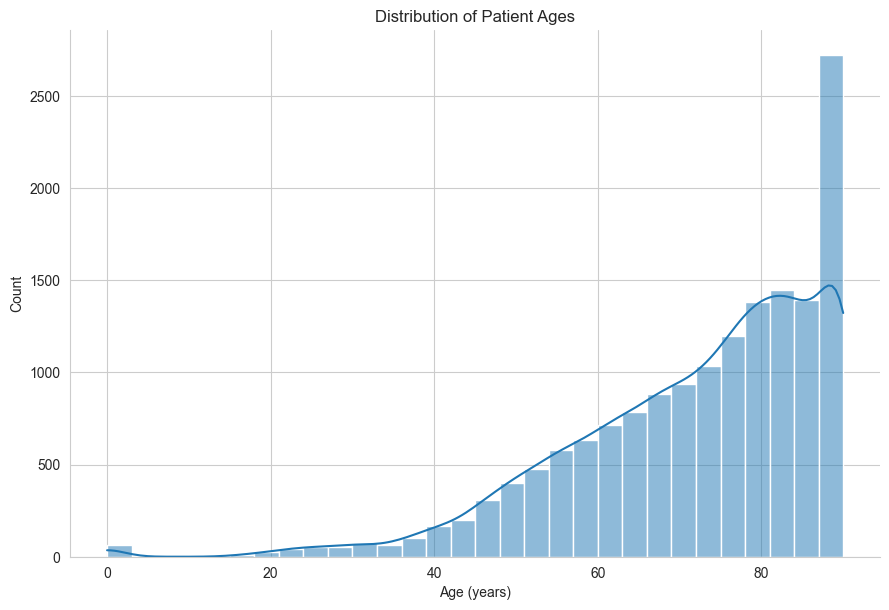

In [12]:
# Visualization 1: Distribution of Patient Ages
sns.displot(data=patients, x='AGE', kde=True, bins=30, height=6, aspect=1.5)
plt.title('Distribution of Patient Ages')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()


### Relationship between Age and Length of Stay using Seaborn relplot visualization

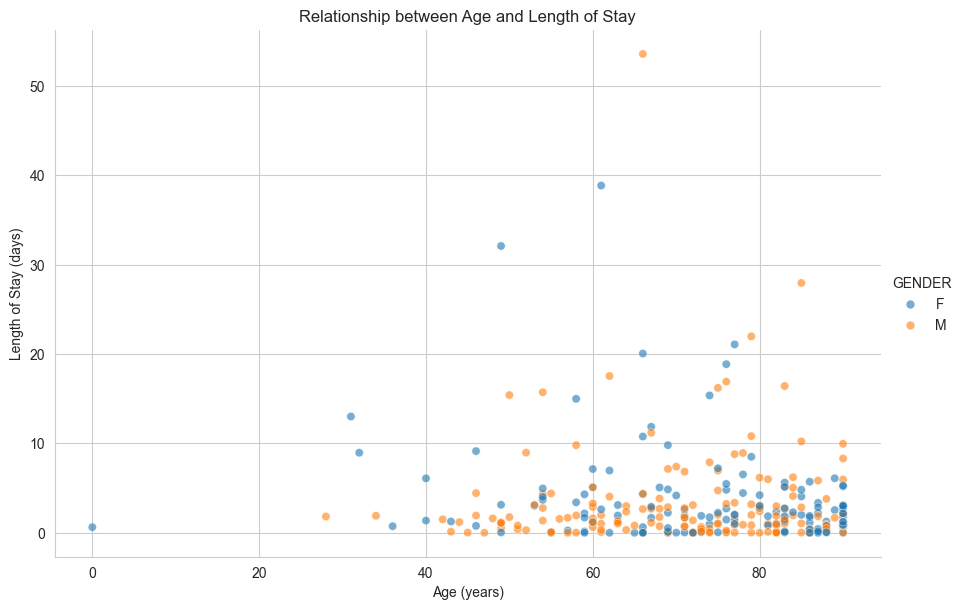

In [13]:
# Visualization 2: Relationship between Age and Length of Stay
sns.relplot(
    data=pt_transfers.sample(1000),  # Sample for performance
    x='AGE', 
    y='LOS', 
    hue='GENDER', 
    alpha=0.6,
    height=6,
    aspect=1.5
)
plt.title('Relationship between Age and Length of Stay')
plt.xlabel('Age (years)')
plt.ylabel('Length of Stay (days)')
plt.show()

### Gender Distribution visualization using Plotly Pie Chart

In [14]:
# Visualization 3: Plotly Pie Chart - Gender Distribution
gender_counts = patients['GENDER'].value_counts()
fig = px.pie(
    gender_counts, 
    values=gender_counts.values, 
    names=gender_counts.index,
    title='Patient Gender Distribution'
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Top Medication Categories visualization using Plotly Donut Chart

In [15]:
# Visualization 4: Plotly Donut Chart - Top Medication Categories
med_counts = pt_prescriptions['DRUG_CATEGORY'].value_counts()
fig = px.pie(
    med_counts,
    values=med_counts.values,
    names=med_counts.index,
    hole=0.4,
    title='Top Medication Categories'
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Average Length of Stay visualization using Plotly Gauge Chart

In [16]:
# Visualization 5: Plotly Gauge Chart - Average Length of Stay
avg_los = pt_transfers['LOS'].mean()
fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = avg_los,
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': "Average Length of Stay (days)"},
    gauge = {
        'axis': {'range': [0, 15]},
        'steps': [
            {'range': [0, 5], 'color': "lightgreen"},
            {'range': [5, 10], 'color': "yellow"},
            {'range': [10, 15], 'color': "red"}],
        'threshold': {
            'line': {'color': "black", 'width': 4},
            'thickness': 0.75,
            'value': avg_los}}))
fig.show()

### Medication by Gender visualization using Plotly Tornado Chart

In [17]:
# Visualization 6: Plotly Tornado Chart - Medication by Gender
med_gender = pt_prescriptions.groupby(['DRUG_CATEGORY', 'GENDER']).size().unstack()
med_gender = med_gender.loc[top_meds]  # Only show top meds

fig = go.Figure()
fig.add_trace(go.Bar(
    y=med_gender.index,
    x=med_gender['M'],
    name='Male',
    orientation='h',
    marker=dict(color='blue')
))
fig.add_trace(go.Bar(
    y=med_gender.index,
    x=-med_gender['F'],
    name='Female',
    orientation='h',
    marker=dict(color='pink')
))

fig.update_layout(
    title='Medication Distribution by Gender (Tornado Chart)',
    barmode='relative',
    xaxis=dict(title='Count', tickvals=[-500, -250, 0, 250, 500], ticktext=['500', '250', '0', '250', '500']),
    height=600
)
fig.show()

### Patient Transfer Network visualization using NetworkX Graph

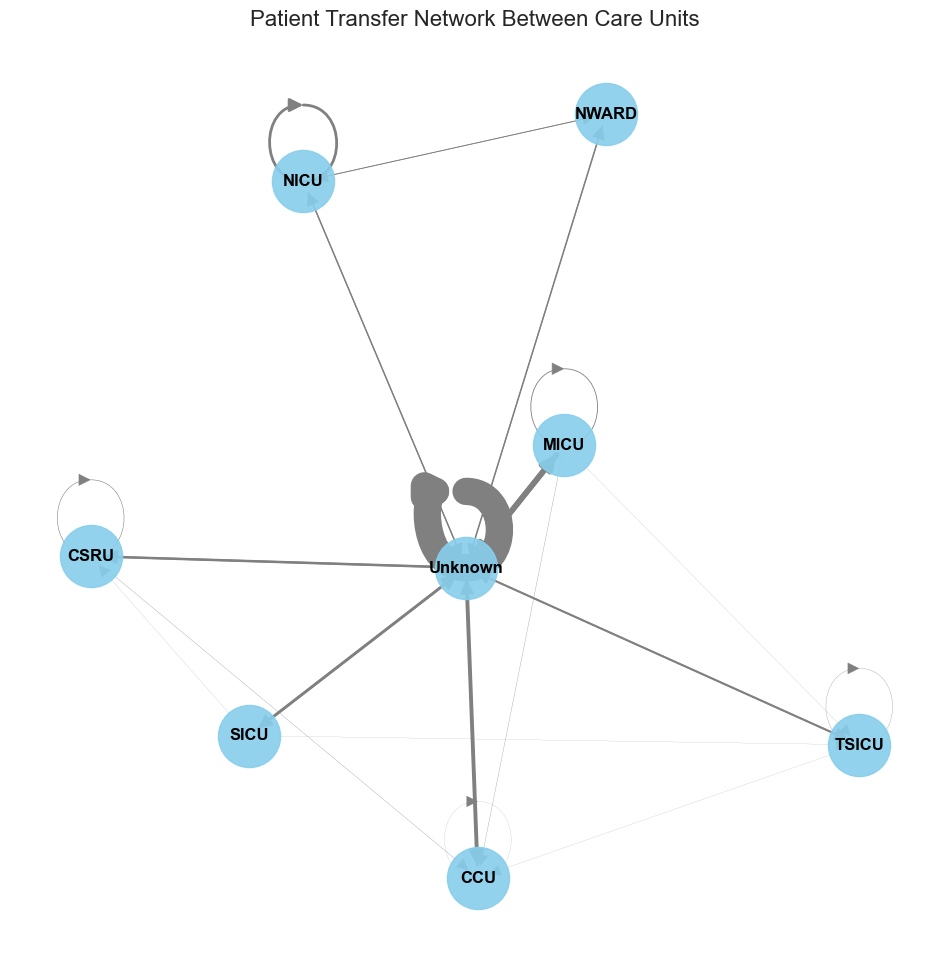

In [18]:
# NetworkX Graph: Patient Transfer Network

# Create a sample of transfers for visualization
sample_transfers = pt_transfers.sample(500, random_state=42)

# Create a directed graph
G = nx.DiGraph()

# Add edges (transfers between units)
for _, row in sample_transfers.iterrows():
    source = row['CURR_CAREUNIT'] if pd.notna(row['CURR_CAREUNIT']) else 'Unknown'
    target = row['PREV_CAREUNIT'] if pd.notna(row['PREV_CAREUNIT']) else 'Unknown'
    
    if G.has_edge(source, target):
        G[source][target]['weight'] += 1
    else:
        G.add_edge(source, target, weight=1)

# Position nodes using spring layout
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(
    G, pos, 
    width=[d['weight']*0.1 for (u, v, d) in G.edges(data=True)], 
    edge_color='gray', 
    arrows=True,
    arrowsize=20
)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title('Patient Transfer Network Between Care Units', fontsize=16)
plt.axis('off')
plt.show()

In [19]:
# Network Metrics
print("Network Density:", nx.density(G))
print("Number of Nodes:", G.number_of_nodes())
print("Number of Edges:", G.number_of_edges())
print("Most Connected Unit:", max(dict(G.degree()).items(), key=lambda x: x[1]))


Network Density: 0.5
Number of Nodes: 8
Number of Edges: 28
Most Connected Unit: ('Unknown', 16)


### **Conclusion**

We analyzed the MIMIC III dataset by taking Patient data in relationship with PRESCRIPTIONS and TRANSFERS tables. Various visualizations are used using 
- Seaborn displot and relplot
- Plotly Piechart, donut chart, guage chart and Tornado chart
- NetworkX Graph to show Patient transfer network
